In [1]:
# Cell 1: Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Define BConvLSTM and Hidden Attention Module
import torch
import torch.nn as nn

# ConvLSTM Cell (single direction)
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, padding=1):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = padding
        # Convolution for input-to-state and state-to-state transitions
        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,  # For input, forget, cell, output gates
            kernel_size=kernel_size,
            padding=padding,
            bias=True
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        # Concatenate input and previous hidden state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # [batch, input_dim + hidden_dim, height, width]
        combined_conv = self.conv(combined)
        # Split into gates
        cc_i, cc_f, cc_c, cc_o = torch.split(combined_conv, self.hidden_dim, dim=1)
        # Gate activations
        i = torch.sigmoid(cc_i)  # Input gate
        f = torch.sigmoid(cc_f)  # Forget gate
        o = torch.sigmoid(cc_o)  # Output gate
        c_next = f * c_cur + i * torch.tanh(cc_c)  # Cell state
        h_next = o * torch.tanh(c_next)  # Hidden state
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

# Bidirectional ConvLSTM
class BConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, padding=1):
        super(BConvLSTM, self).__init__()
        self.forward_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size, padding)
        self.backward_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size, padding)
        # Final convolution to combine forward and backward outputs
        self.conv_out = nn.Conv2d(hidden_dim * 2, hidden_dim, kernel_size=1, padding=0)

    def forward(self, x):
        # x: [batch, channels, height, width]
        batch_size, _, height, width = x.size()
        # Initialize hidden states
        h_f, c_f = self.forward_cell.init_hidden(batch_size, (height, width))
        h_b, c_b = self.backward_cell.init_hidden(batch_size, (height, width))
        
        # Forward pass
        h_forward = []
        for t in range(1):  # Single time step (as input is a single feature map)
            h_f, c_f = self.forward_cell(x, cur_state=[h_f, c_f])
            h_forward.append(h_f)
        h_forward = h_forward[0]  # [batch, hidden_dim, height, width]
        
        # Backward pass
        h_backward = []
        for t in range(1):  # Single time step
            h_b, c_b = self.backward_cell(x, cur_state=[h_b, c_b])
            h_backward.append(h_b)
        h_backward = h_backward[0]  # [batch, hidden_dim, height, width]
        
        # Combine forward and backward
        h_combined = torch.cat([h_forward, h_backward], dim=1)  # [batch, hidden_dim*2, height, width]
        output = self.conv_out(h_combined)  # [batch, hidden_dim, height, width]
        return output

# Hidden Attention Module with BConvLSTM
class HiddenAttentionModule(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(HiddenAttentionModule, self).__init__()
        # First Conv Layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second Conv Layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # SE Block
        self.se_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 16, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        # Shortcut Connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )
        # BConvLSTM
        self.bconvlstm = BConvLSTM(input_dim=out_channels, hidden_dim=out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        # Conv Path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # SE Block
        se = self.se_block(out)
        out = out * se
        # Shortcut
        identity = self.shortcut(identity)
        out += identity
        out = self.relu(out)
        # BConvLSTM
        out = self.bconvlstm(out)
        return out

In [3]:
# Cell 3: Define HA-ResNet Model (with Dropout)
class HA_ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(HA_ResNet, self).__init__()
        self.embedding = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.ham1 = HiddenAttentionModule(64, 64, stride=1)
        self.ham2 = HiddenAttentionModule(64, 128, stride=2)
        self.ham3 = HiddenAttentionModule(128, 256, stride=2)
        self.ham4 = HiddenAttentionModule(256, 512, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)  # Add dropout
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.ham1(x)
        x = self.ham2(x)
        x = self.ham3(x)
        x = self.ham4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [4]:
# Cell 4: Define Custom Dataset (Updated to Preload Images)
class GaitGAFDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        # Preload images into memory
        print("Preloading images into memory...")
        self.images = []
        for img_path in tqdm(image_paths, desc="Loading images"):
            image = Image.open(img_path).convert('RGB')
            self.images.append(image)
        print(f"Loaded {len(self.images)} images into memory.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
# Cell 5: Create Dataset Mapping for HA-ResNet Training
import os
import glob

# Define label mapping
label_mapping = {
    "als": 0,
    "control": 1,
    "hunt": 2,
    "park": 3
}

# Base directory
base_dir = os.path.join(os.getcwd(), "gait-in-neurodegenerative-disease-database-1.0.0", "gaf_images_augmented")

# Collect image paths and labels
dataset_mapping = []
groups = ["als", "control", "hunt", "park"]
feature_columns = [
    "L_Stride", "R_Stride", "L_Swing", "R_Swing", "L_Swing%", "R_Swing%", 
    "L_Stance", "R_Stance", "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
]

print("Creating dataset mapping for HA-ResNet training...")
for group in groups:
    label = label_mapping[group]
    for feature in feature_columns:
        feature_dir = os.path.join(base_dir, group, feature)
        if not os.path.exists(feature_dir):
            print(f"Warning: Directory not found: {feature_dir}")
            continue
        
        # Find all .png files in the feature directory
        image_paths = glob.glob(os.path.join(feature_dir, "*.png"))
        for image_path in image_paths:
            dataset_mapping.append((image_path, label))
        
        print(f"Collected {len(image_paths)} images for {group}/{feature}")

# Verify total images
print(f"\nTotal images in dataset: {len(dataset_mapping)} (expected 3072)")
if len(dataset_mapping) != 3072:
    print(f"Warning: Expected 3072 images (64 subjects × 12 features × 4 versions), but found {len(dataset_mapping)}.")

# Example entry
if dataset_mapping:
    print(f"Example entry: {dataset_mapping[0]}")

Creating dataset mapping for HA-ResNet training...
Collected 52 images for als/L_Stride
Collected 52 images for als/R_Stride
Collected 52 images for als/L_Swing
Collected 52 images for als/R_Swing
Collected 52 images for als/L_Swing%
Collected 52 images for als/R_Swing%
Collected 52 images for als/L_Stance
Collected 52 images for als/R_Stance
Collected 52 images for als/L_Stance%
Collected 52 images for als/R_Stance%
Collected 52 images for als/DoubleSupport
Collected 52 images for als/DoubleSupport%
Collected 64 images for control/L_Stride
Collected 64 images for control/R_Stride
Collected 64 images for control/L_Swing
Collected 64 images for control/R_Swing
Collected 64 images for control/L_Swing%
Collected 64 images for control/R_Swing%
Collected 64 images for control/L_Stance
Collected 64 images for control/R_Stance
Collected 64 images for control/L_Stance%
Collected 64 images for control/R_Stance%
Collected 64 images for control/DoubleSupport
Collected 64 images for control/Double

In [9]:
# Cell 6: Prepare Dataset and DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torchvision import transforms

# Extract image paths and labels from dataset_mapping (from Cell 5)
image_paths = [item[0] for item in dataset_mapping]
labels = [item[1] for item in dataset_mapping]

# Split dataset into train, validation, and test sets (70% train, 10% val, 20% test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.1/0.8, stratify=train_val_labels, random_state=42
)

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = GaitGAFDataset(train_paths, train_labels, transform=transform)
val_dataset = GaitGAFDataset(val_paths, val_labels, transform=transform)
test_dataset = GaitGAFDataset(test_paths, test_labels, transform=transform)

# Compute class weights for WeightedRandomSampler (to handle class imbalance)
label_counts = Counter(train_labels)
num_samples = len(train_labels)
class_weights = {i: num_samples / (len(label_counts) * count) for i, count in label_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders with optimized settings
batch_size = 32 
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

# Print dataset sizes and class distributions
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Training class distribution: {Counter(train_labels)}")
print(f"Validation class distribution: {Counter(val_labels)}")
print(f"Test class distribution: {Counter(test_labels)}")

Preloading images into memory...


Loading images:   0%|          | 0/2149 [00:00<?, ?it/s]

Loaded 2149 images into memory.
Preloading images into memory...


Loading images:   0%|          | 0/308 [00:00<?, ?it/s]

Loaded 308 images into memory.
Preloading images into memory...


Loading images:   0%|          | 0/615 [00:00<?, ?it/s]

Loaded 615 images into memory.
Training dataset size: 2149
Validation dataset size: 308
Test dataset size: 615
Training class distribution: Counter({2: 672, 1: 537, 3: 504, 0: 436})
Validation class distribution: Counter({2: 96, 1: 77, 3: 72, 0: 63})
Test class distribution: Counter({2: 192, 1: 154, 3: 144, 0: 125})


In [10]:
# Cell 7: Training and Evaluation Functions (Updated for Mixed Precision)
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    scaler = GradScaler()  # For mixed precision training
    best_val_f1 = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_true = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():  # Mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.tolist())
            train_true.extend(labels.tolist())
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = accuracy_score(train_true, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_true, train_preds, average='weighted', zero_division=0
        )

        # Validation
        model.eval()
        val_preds = []
        val_true = []
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.tolist())
                val_true.extend(labels.tolist())
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(val_true, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_true, val_preds, average='weighted', zero_division=0
        )

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train - Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
        print(f"Unique predicted classes (val): {np.unique(val_preds)}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_ha_resnet.pth')

def evaluate_model(model, test_loader, device):
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.tolist())
            true.extend(labels.tolist())

    accuracy = accuracy_score(true, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true, preds, average='weighted', zero_division=0
    )
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Unique predicted classes (test): {np.unique(preds)}")

    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ALS', 'Control', 'Huntington', 'Parkinson'],
                yticklabels=['ALS', 'Control', 'Huntington', 'Parkinson'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50
Train - Loss: 1.1820, Accuracy: 0.4532, F1: 0.4471
Val   - Loss: 1.2649, Accuracy: 0.4253, F1: 0.3752
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/50
Train - Loss: 0.8006, Accuracy: 0.6812, F1: 0.6788
Val   - Loss: 1.4985, Accuracy: 0.5909, F1: 0.5743
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/50
Train - Loss: 0.5138, Accuracy: 0.8046, F1: 0.8040
Val   - Loss: 1.0451, Accuracy: 0.6006, F1: 0.5615
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/50
Train - Loss: 0.3431, Accuracy: 0.8776, F1: 0.8772
Val   - Loss: 0.5646, Accuracy: 0.8019, F1: 0.8023
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/50
Train - Loss: 0.2807, Accuracy: 0.9069, F1: 0.9068
Val   - Loss: 0.6234, Accuracy: 0.8117, F1: 0.8113
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/50
Train - Loss: 0.1827, Accuracy: 0.9414, F1: 0.9414
Val   - Loss: 0.6721, Accuracy: 0.7890, F1: 0.7894
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/50
Train - Loss: 0.1269, Accuracy: 0.9572, F1: 0.9572
Val   - Loss: 0.6994, Accuracy: 0.7825, F1: 0.7804
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/50
Train - Loss: 0.1161, Accuracy: 0.9591, F1: 0.9590
Val   - Loss: 0.7995, Accuracy: 0.7890, F1: 0.7884
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/50
Train - Loss: 0.1510, Accuracy: 0.9470, F1: 0.9469
Val   - Loss: 0.5921, Accuracy: 0.8214, F1: 0.8218
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/50
Train - Loss: 0.1458, Accuracy: 0.9511, F1: 0.9511
Val   - Loss: 0.9409, Accuracy: 0.7208, F1: 0.7051
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11/50
Train - Loss: 0.0768, Accuracy: 0.9753, F1: 0.9753
Val   - Loss: 0.5911, Accuracy: 0.8474, F1: 0.8469
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12/50
Train - Loss: 0.0393, Accuracy: 0.9893, F1: 0.9893
Val   - Loss: 0.5459, Accuracy: 0.8636, F1: 0.8640
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13/50
Train - Loss: 0.0554, Accuracy: 0.9819, F1: 0.9818
Val   - Loss: 0.7224, Accuracy: 0.8279, F1: 0.8294
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14/50
Train - Loss: 0.0830, Accuracy: 0.9702, F1: 0.9702
Val   - Loss: 0.6317, Accuracy: 0.8442, F1: 0.8438
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15/50
Train - Loss: 0.0498, Accuracy: 0.9837, F1: 0.9837
Val   - Loss: 0.6074, Accuracy: 0.8474, F1: 0.8477
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16/50
Train - Loss: 0.1114, Accuracy: 0.9651, F1: 0.9651
Val   - Loss: 0.5842, Accuracy: 0.8669, F1: 0.8673
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17/50
Train - Loss: 0.0341, Accuracy: 0.9898, F1: 0.9898
Val   - Loss: 0.5170, Accuracy: 0.8734, F1: 0.8737
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18/50
Train - Loss: 0.0251, Accuracy: 0.9921, F1: 0.9921
Val   - Loss: 0.5492, Accuracy: 0.8636, F1: 0.8643
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19/50
Train - Loss: 0.0241, Accuracy: 0.9893, F1: 0.9893
Val   - Loss: 0.5766, Accuracy: 0.8701, F1: 0.8702
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20/50
Train - Loss: 0.0294, Accuracy: 0.9888, F1: 0.9888
Val   - Loss: 1.2294, Accuracy: 0.7468, F1: 0.7256
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21/50
Train - Loss: 0.0442, Accuracy: 0.9865, F1: 0.9865
Val   - Loss: 0.6269, Accuracy: 0.8766, F1: 0.8762
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22/50
Train - Loss: 0.0753, Accuracy: 0.9730, F1: 0.9730
Val   - Loss: 0.5828, Accuracy: 0.8539, F1: 0.8534
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23/50
Train - Loss: 0.1255, Accuracy: 0.9563, F1: 0.9562
Val   - Loss: 0.6222, Accuracy: 0.8344, F1: 0.8353
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24/50
Train - Loss: 0.0342, Accuracy: 0.9884, F1: 0.9884
Val   - Loss: 0.4855, Accuracy: 0.8994, F1: 0.8993
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25/50
Train - Loss: 0.0528, Accuracy: 0.9814, F1: 0.9814
Val   - Loss: 0.6004, Accuracy: 0.8701, F1: 0.8700
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 26/50
Train - Loss: 0.0616, Accuracy: 0.9814, F1: 0.9814
Val   - Loss: 0.4950, Accuracy: 0.8636, F1: 0.8644
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 27/50
Train - Loss: 0.0496, Accuracy: 0.9814, F1: 0.9814
Val   - Loss: 0.6241, Accuracy: 0.8539, F1: 0.8548
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 28/50
Train - Loss: 0.0137, Accuracy: 0.9958, F1: 0.9958
Val   - Loss: 0.5132, Accuracy: 0.8896, F1: 0.8897
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 29/50
Train - Loss: 0.0244, Accuracy: 0.9912, F1: 0.9912
Val   - Loss: 0.5388, Accuracy: 0.8506, F1: 0.8500
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 30/50
Train - Loss: 0.0292, Accuracy: 0.9912, F1: 0.9912
Val   - Loss: 0.5663, Accuracy: 0.8896, F1: 0.8900
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 31/50
Train - Loss: 0.0300, Accuracy: 0.9916, F1: 0.9916
Val   - Loss: 0.6760, Accuracy: 0.8636, F1: 0.8647
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 32/50
Train - Loss: 0.0263, Accuracy: 0.9916, F1: 0.9916
Val   - Loss: 0.6149, Accuracy: 0.8734, F1: 0.8739
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 33/50
Train - Loss: 0.0922, Accuracy: 0.9730, F1: 0.9730
Val   - Loss: 0.5291, Accuracy: 0.8636, F1: 0.8644
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 34/50
Train - Loss: 0.0406, Accuracy: 0.9870, F1: 0.9870
Val   - Loss: 0.6040, Accuracy: 0.8734, F1: 0.8729
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 35/50
Train - Loss: 0.0131, Accuracy: 0.9958, F1: 0.9958
Val   - Loss: 0.6441, Accuracy: 0.8604, F1: 0.8601
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 36/50
Train - Loss: 0.0045, Accuracy: 0.9991, F1: 0.9991
Val   - Loss: 0.5311, Accuracy: 0.8961, F1: 0.8959
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 37/50
Train - Loss: 0.0045, Accuracy: 0.9986, F1: 0.9986
Val   - Loss: 0.5257, Accuracy: 0.8994, F1: 0.8992
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 38/50
Train - Loss: 0.0029, Accuracy: 0.9991, F1: 0.9991
Val   - Loss: 0.5410, Accuracy: 0.8994, F1: 0.8996
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 39/50
Train - Loss: 0.0111, Accuracy: 0.9940, F1: 0.9939
Val   - Loss: 0.9127, Accuracy: 0.8506, F1: 0.8514
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 40/50
Train - Loss: 0.0558, Accuracy: 0.9823, F1: 0.9823
Val   - Loss: 0.7580, Accuracy: 0.8636, F1: 0.8650
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 41/50
Train - Loss: 0.0566, Accuracy: 0.9823, F1: 0.9823
Val   - Loss: 0.7397, Accuracy: 0.8344, F1: 0.8342
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 42/50
Train - Loss: 0.0682, Accuracy: 0.9781, F1: 0.9781
Val   - Loss: 0.6129, Accuracy: 0.8636, F1: 0.8634
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 43/50
Train - Loss: 0.0083, Accuracy: 0.9972, F1: 0.9972
Val   - Loss: 0.6042, Accuracy: 0.8701, F1: 0.8706
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 44/50
Train - Loss: 0.0560, Accuracy: 0.9832, F1: 0.9832
Val   - Loss: 0.7034, Accuracy: 0.8474, F1: 0.8484
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 45/50
Train - Loss: 0.0111, Accuracy: 0.9972, F1: 0.9972
Val   - Loss: 0.6894, Accuracy: 0.8799, F1: 0.8799
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 46/50
Train - Loss: 0.1019, Accuracy: 0.9665, F1: 0.9664
Val   - Loss: 0.5336, Accuracy: 0.8799, F1: 0.8807
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 47/50
Train - Loss: 0.0155, Accuracy: 0.9949, F1: 0.9949
Val   - Loss: 0.4513, Accuracy: 0.8994, F1: 0.8992
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 48/50
Train - Loss: 0.0113, Accuracy: 0.9963, F1: 0.9963
Val   - Loss: 0.4711, Accuracy: 0.9026, F1: 0.9027
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 49/50
Train - Loss: 0.0043, Accuracy: 0.9981, F1: 0.9981
Val   - Loss: 0.5297, Accuracy: 0.8929, F1: 0.8930
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 50/50
Train - Loss: 0.0024, Accuracy: 1.0000, F1: 1.0000
Val   - Loss: 0.4909, Accuracy: 0.8961, F1: 0.8962
Unique predicted classes (val): [0 1 2 3]


C:\Users\piyus\AppData\Local\Temp\ipykernel_26056\2061534308.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Test Accuracy: 0.8585
Test Precision: 0.8598
Test Recall: 0.8585
Test F1-Score: 0.8588
Unique predicted classes (test): [0 1 2 3]


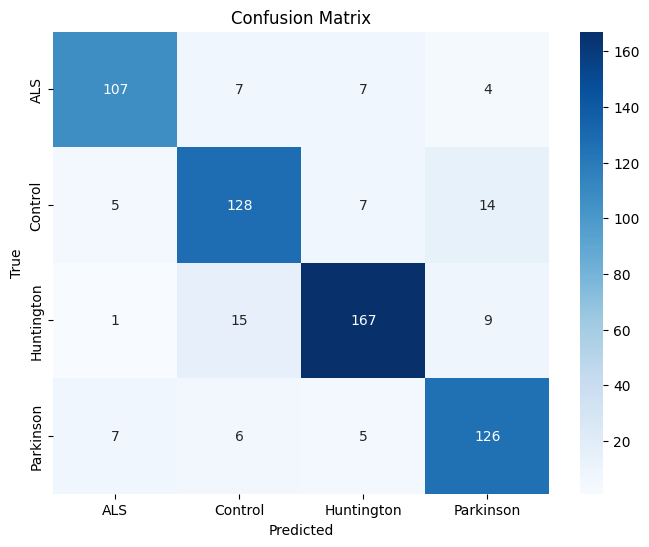

In [11]:
# Cell 8: Main Execution (Train and Evaluate Model)
# Initialize model
model = HA_ResNet(num_classes=4).to(device)

# Class weights for imbalanced dataset (inverse of class frequencies)
class_weights = torch.tensor([3072/624, 3072/768, 3072/960, 3072/720], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
learning_rate = 0.0001  # As per paper
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Training parameters
num_epochs = 50  # Restored to original value

# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Load best model and evaluate
model.load_state_dict(torch.load('best_ha_resnet.pth'))
evaluate_model(model, test_loader, device)